<a href="https://colab.research.google.com/github/Fikaaw/quantitative-analysis/blob/main/early_warning_system_low_default_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://stackoverflow.com/questions/78305636/early-warning-system-low-default-portfolio-datasets-in-r?newreg=8633529f177e40cf9a5a6cd720c4d24f

The main issues you're facing are:

1. Unrealistic default rates (50% instead of the intended 1% over 5 years)
2. Issues with creating new loans and handling defaulted credit lines

Here's an approach to solve these problems:

1. Adjust the transition probabilities:
*   The current transition probabilities are too high for a low-default portfolio. Let's modify them to reflect lower default rates.
2. Implement a more realistic loan lifecycle:
*   Add loan maturity dates
*   Remove loans that have matured
*   Add new loans periodically to maintain the portfolio size
3. Improve the default handling:
*   Once a loan defaults, it should remain in default
*   Implement a recovery process for defaulted loans
4. Add more realistic features:
*   Implement seasonal effects on default rates
*   Add macroeconomic factors that influence default rates

date                 2023-12-01 00:00:00
total_loans                         5000
default_rate                      0.0128
avg_loan_amount            637109.440171
avg_interest_rate                0.03493
avg_ltv_ratio                   0.725111
Name: 59, dtype: object


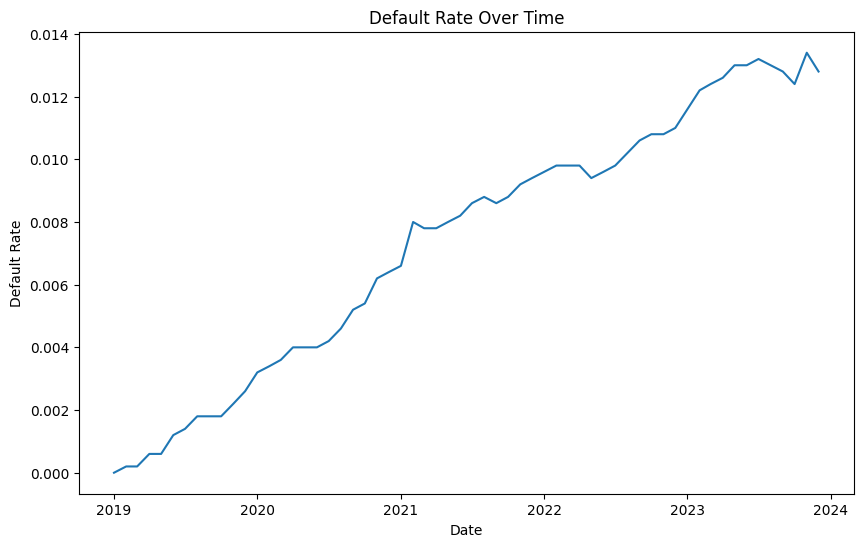

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

np.random.seed(42)

# Initialize the portfolio
def initialize_portfolio(n_loans):
    return pd.DataFrame({
        'credit_id': range(1, n_loans + 1),
        'issue_date': pd.date_range(start='2015-01-01', end='2019-01-01', periods=n_loans),
        'maturity_date': pd.date_range(start='2015-01-01', end='2019-01-01', periods=n_loans) + pd.to_timedelta(np.random.randint(5*365, 10*365, n_loans), unit='D'),
        'loan_amount': np.random.uniform(35000, 1250000, n_loans),
        'current_rating': np.random.choice(['AAA', 'AA', 'A', 'BBB', 'BB', 'B'], n_loans, p=[0.05, 0.1, 0.2, 0.3, 0.25, 0.1]),
        'ead': np.random.uniform(28000, 1000000, n_loans),
        'ltv_ratio': np.random.uniform(0.5, 0.95, n_loans),
        'interest_rate': np.random.uniform(0.02, 0.05, n_loans),
        'days_past_due': 0,
        'default_status': False
    })

# Define transition probabilities for a low-default portfolio
transition_probs = {
    'AAA': {'AAA': 0.99, 'AA': 0.009, 'A': 0.0009, 'Default': 0.0001},
    'AA': {'AA': 0.98, 'A': 0.019, 'BBB': 0.0009, 'Default': 0.0001},
    'A': {'A': 0.97, 'BBB': 0.029, 'BB': 0.0009, 'Default': 0.0001},
    'BBB': {'BBB': 0.96, 'BB': 0.039, 'B': 0.0009, 'Default': 0.0001},
    'B': {'B': 0.94, 'BB': 0.055, 'BBB': 0.0045, 'Default': 0.0005},
    'BB': {'BB': 0.95, 'B': 0.045, 'BBB': 0.0045, 'Default': 0.0005}
}

# Simulate transitions
def simulate_transition(rating):
    if rating == 'Default':
        return 'Default'
    probs = transition_probs[rating]
    return np.random.choice(list(probs.keys()), p=list(probs.values()))

# Simulate portfolio for one month
def simulate_month(portfolio, current_date, macro_factor):
    # Update loan status
    portfolio['current_rating'] = portfolio['current_rating'].apply(simulate_transition)
    portfolio['days_past_due'] = np.where(
        np.random.random(len(portfolio)) < 0.05 * macro_factor,
        portfolio['days_past_due'] + np.random.randint(0, 31, len(portfolio)),
        0
    )
    portfolio['default_status'] = (portfolio['days_past_due'] > 90) | (portfolio['current_rating'] == 'Default')
    portfolio.loc[portfolio['default_status'], 'current_rating'] = 'Default'

    # Remove matured loans
    matured_loans = (portfolio['maturity_date'] <= current_date).sum()
    portfolio = portfolio[portfolio['maturity_date'] > current_date]

    # Add new loans
    new_loans = initialize_portfolio(matured_loans)
    new_loans['issue_date'] = current_date
    new_loans['maturity_date'] = current_date + pd.to_timedelta(np.random.randint(5*365, 10*365, matured_loans), unit='D')

    return pd.concat([portfolio, new_loans], ignore_index=True)

# Run simulation
def run_simulation(initial_portfolio, start_date, end_date):
    current_date = start_date
    portfolio = initial_portfolio
    results = []

    while current_date <= end_date:
        # Simulate macroeconomic factor (simplified)
        macro_factor = np.random.normal(1, 0.1)

        portfolio = simulate_month(portfolio, current_date, macro_factor)

        # Store results
        results.append({
            'date': current_date,
            'total_loans': len(portfolio),
            'default_rate': portfolio['default_status'].mean(),
            'avg_loan_amount': portfolio['loan_amount'].mean(),
            'avg_interest_rate': portfolio['interest_rate'].mean(),
            'avg_ltv_ratio': portfolio['ltv_ratio'].mean()
        })

        current_date += pd.DateOffset(months=1)

    return pd.DataFrame(results)

# Initialize and run simulation
initial_portfolio = initialize_portfolio(5000)
start_date = pd.to_datetime('2019-01-01')
end_date = pd.to_datetime('2023-12-31')

simulation_results = run_simulation(initial_portfolio, start_date, end_date)

# Print final results
print(simulation_results.iloc[-1])

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(simulation_results['date'], simulation_results['default_rate'])
plt.title('Default Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Default Rate')
plt.show()